# Linear Transformations 

A linear transformation is a mapping between vector spaces that 
preserves addition and scalar multiplication. A map $L: V \to W$
is a linear transformation from $V$ to $W$ if 

$$L(a x_1  + b x_2) = a L(x_1) + bL(x_2)$$

For all $x_1, x_2 \in V$ and scalars $a, b \in \mathbb{F}$.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
%matplotlib inline

In [2]:
# load the dataset
data = np.load('../data/horse.npy')

In [3]:
data.shape

(2, 59520)

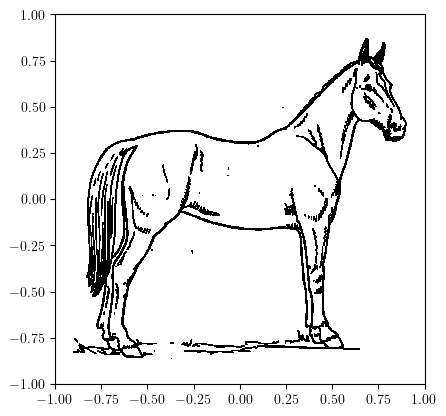

In [4]:
# use markers , = pixel
# reference https://matplotlib.org/stable/api/markers_api.html
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.plot(data[0], data[1], 'k,')
# make plot square 
plt.axis([-1, 1, -1, 1])
plt.gca().set_aspect("equal");

## Types of Linear Transformations

- Stretch 

$$
\begin{bmatrix}
a & 0  \\ 
0 & b 
\end{bmatrix}
$$

if $a = b$, then it is called _dilation_. $a$ works on x-axis and $b$ works on y-axis. 

- Shear

$$
\begin{bmatrix}
1 & a  \\ 
b & 1 
\end{bmatrix}
$$

Pure horizontal shears ($b=0$) skew the x-coordinate of
the vector while pure vertical shears ($a=0$) skew the
y-coordinate. 

- Reflection: reflect the vector about a line that passes
through the origin. The reflection about the line spanned
by the vector $[a, b]^T$ has the matrix representation 

$$
\frac{1}{a^2 + b^2} 
\begin{bmatrix}
a^2-b^2 & 2ab  \\ 
2ab & b^2-a^2 
\end{bmatrix}
$$


- Rotation:

$$
\begin{bmatrix}
\cos \theta & - \sin \theta  \\ 
\sin \theta & \cos \theta
\end{bmatrix}
$$

A negative value of $\theta$ performs a clockwise rotation. Choosing $\theta = \pi/4$ produces the the following figure. 

In [5]:
def linear_transformation(mat_a: np.ndarray, transform=None):
    """
    Operating linear transformation on mat_a
    ------------
    Parameters of transformation was fixed to demonstrate 
    """
    if transform is None:
        return mat_a 

    # initialize transform matrix 
    transform_mat = np.zeros((2, 2))

    transform_mat_stretch = np.array(
            [
                [1/2, 0],
                [0, 6/5]
            ]
        )
    
    transform_mat_shear = np.array(
            [
                [1, 1/2],
                [0,1]
            ]
        )
    
    a, b = 0, 1
    transform_mat_reflection = np.array(
        [
            [a**2-b**2, 2*a*b],
            [2*a*b,b**2-a**2]
        ]
    )/(a**2 + b**2)

    theta = np.pi/2
    transform_mat_rotation = np.array(
        [
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),np.cos(theta)]
        ]
    )
    if transform == 'stretch':
        mat_a = transform_mat_stretch @ mat_a 
    elif transform == 'shear':
        mat_a = transform_mat_shear @ mat_a 
    elif transform == 'reflection':
        mat_a = transform_mat_reflection @ mat_a 
    elif transform == 'rotation':
        mat_a = transform_mat_rotation @ mat_a 
    else:
        # do all transformation 
        mat_a = transform_mat_stretch @ mat_a
        mat_a = transform_mat_shear @ mat_a 
        mat_a = transform_mat_reflection @ mat_a
        mat_a = transform_mat_rotation @ mat_a 

    return mat_a

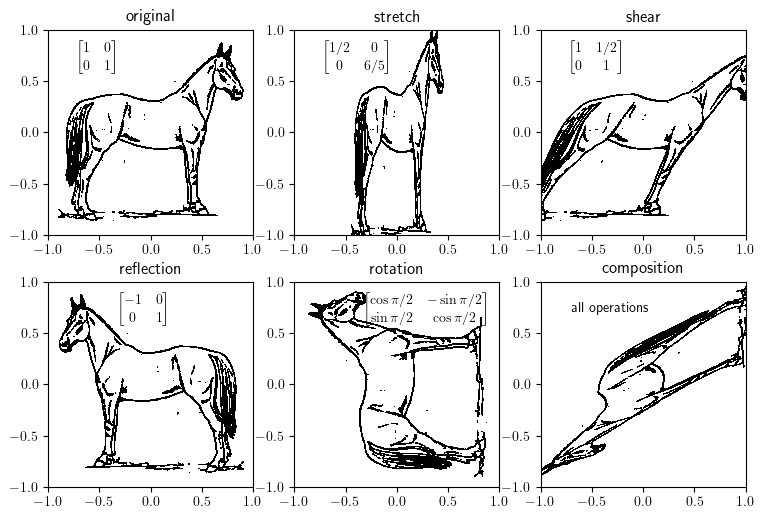

In [28]:
# plot all transformation
trans_title = [None, 'stretch', 'shear',
               'reflection', 'rotation', 'composition']
tex1 = r'$\begin{bmatrix} \cos \pi/2 & -\sin \pi/2 \\'
tex2 = r' \sin \pi/2 &  \cos \pi/2 \end{bmatrix}$'
trans_text = [
    r'$\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$',
    r'$\begin{bmatrix} 1/2 & 0 \\ 0 & 6/5 \end{bmatrix}$',
    r'$\begin{bmatrix} 1 & 1/2 \\ 0 & 1 \end{bmatrix}$',
    r'$\begin{bmatrix} -1 & 0 \\ 0 & 1 \end{bmatrix}$',
    tex1 + tex2
]

matplotlib_inline.backend_inline.set_matplotlib_formats('png')

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
axs = axes.ravel()

for i, t in enumerate(trans_title):
    # transform
    tmp = linear_transformation(data, t)
    axs[i].plot(tmp[0], tmp[1], 'k,')
    axs[i].axis([-1, 1, -1, 1])
    axs[i].set_aspect("equal")
    if t is None:
        axs[i].set_title('original')
    else:
        axs[i].set_title(t)
    if i < 3:
        axs[i].text(-0.7, 0.7, trans_text[i])
    if i >= 3 and i <5:
        axs[i].text(-0.3, 0.7, trans_text[i])
    if i == 5 :
        axs[i].text(-0.7, 0.7, 'all operations')

## Modeling Motion with Affine Transformations

![moon-motion](../images/moon-motion.png)

 The moon orbits the earth while the earth orbits the sun. Assuming circular
orbits, we can compute the trajectories of both the earth and the moon using 
only linear and affine transformations.

Suppose the planet has _angular_ velocity $\omega$. If $R(\theta)$
is the matrix representation of the linear transformation that
rotates a vector around the origin by $\theta$ radians, then $p(t) = R(t\omega)p(0)$.

In [10]:
# simulate earth and moon motion 
def earth_and_moon(xe: float, xm: float, 
                            omega_e: float, omega_m: float, 
                            T: float):
    """
    A function that simulates the motion of earth and moon 
    """
    # the initial position
    pe0 = np.array(
        [xe, 0]
    )
    pm0 = np.array(
        [xm, 0]
    )

    e_positions = []
    m_positions = []

    def _rotation_matrix(omega, T):
        rotation_e = np.array(
            [
                [np.cos(omega* T), -np.sin(omega * T)],
                [np.sin(omega * T),np.cos(omega * T)]
            ]
        )

        return rotation_e

    steps_num = int(T/0.01)
    discrete_time = np.linspace(0, T, steps_num)

    for t in discrete_time:
        # calcualte rotation for earth and moon
        r_e = _rotation_matrix(omega_e, t)
        r_m = _rotation_matrix(omega_m, t)
        # calcualte the current position
        p_e = r_e @ pe0 
        p_m = r_m @ (pm0  - pe0)  # the postion of moon relative to the eart
        p_m = p_m + p_e  # p_e as base 
        

        e_positions.append(p_e)
        m_positions.append(p_m)

    
    return np.array(e_positions), np.array(m_positions)

In [11]:
T = np.pi * 3 / 2
xe = 10
xm = 11
we = 1
wm = 13
foo_ep, foo_mp = earth_and_moon(xe, xm, we, wm, T)

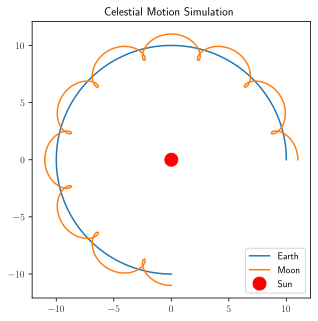

In [14]:
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(foo_ep[:, 0], foo_ep[:, 1], label='Earth')
ax.plot(foo_mp[:, 0], foo_mp[:, 1], label='Moon')
ax.plot(0, 0, 'ro', markersize=13, label='Sun')
ax.set_title("Celestial Motion Simulation")
ax.legend(); 

## Timing Matrix Operations

Linear transformations are easy to perform via matrix multiplication. However, performing matrix
multiplication with very large matrices can strain a machine’s time and memory constraints. For
the remainder of this lab we take an empirical approach in exploring how much time and memory
different matrix operations require.

In [2]:
def for_loop():
    """Time for_loop with time.time()"""
    for _ in range(int(1e7)):
        pass


%timeit for_loop()

117 ms ± 9.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
from random import random
def random_vector(n):
    """Generate a random vector of length n as a list."""
    return [random() for i in range(n)]

def random_matrix(n):
    """Generate a random nxn matrix as a list of lists."""
    return [[random() for j in range(n)] for i in range(n)]

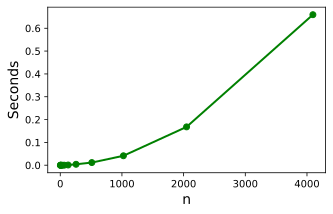

In [6]:
domain = 2**np.arange(1,13)
times = []
for n in domain:
    start = time.time()
    random_matrix(n)
    times.append(time.time()-start)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(domain, times, 'g.-', lw=2, ms=12)
ax.set_xlabel("n", fontsize=14)
ax.set_ylabel("Seconds", fontsize=14);

An algorithm like random_matrix(n) whose execution time increases quadratically with $n$ is called $O\left(n^2\right)$, notated by random_matrix $(\mathrm{n}) \in O\left(n^2\right)$. Big-oh notation is common for indicating both the temporal complexity of an algorithm (how the execution time grows with $n$ ) and the spatial complexity (how the memory usage grows with $n$ ).

In [21]:
def matrix_vector_prod(A, x):
    m, n = len(A), len(x)
    return [sum([A[i][k] * x[k] for k in range(n)]) for i in range(m)]

def matrix_matrix_prod(A, B):
    m, n, p = len(A), len(B), len(B[0])
    prod = [
        [
            sum(
                [A[i][k] * B[k][j] for k in range(n)]
                ) 
                for j in range(p)] 
                for i in range(m)
    ]

    return prod

In [8]:
domain = 2**np.arange(1,10)

vec_times = []
mat_times = []

for n in domain:
    foov = random_vector(n)
    foom = random_matrix(n)
    start = time.time()
    matrix_vector_prod(foom, foov)
    vec_times.append(time.time()-start)
    start = time.time()
    matrix_matrix_prod(foom, foom)
    mat_times.append(time.time()-start)

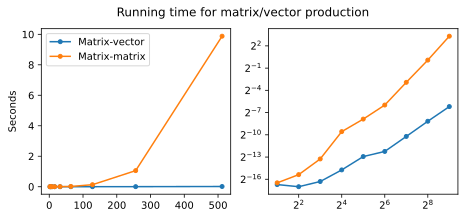

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
vis_data = {
    'Matrix-vector': vec_times,
    'Matrix-matrix': mat_times
}


for data in vis_data.items():
    axes[0].plot(domain, data[1], '.-', ms=8, label=data[0])
    axes[0].set_ylabel('Seconds')
    # log-log scale 
    axes[1].loglog(domain, data[1], '.-', ms=8, base=2)

axes[0].legend(loc='upper left')
fig.suptitle('Running time for matrix/vector production');

In [7]:
# test numpy 
domain = 2**np.arange(1,10)

vec_times = []
mat_times = []
np_vec_times = []
np_mat_times = []

for n in domain:
    foov = random_vector(n)
    foom = random_matrix(n)
    start = time.time()
    matrix_vector_prod(foom, foov)
    vec_times.append(time.time()-start)
    # numpy 
    start = time.time()
    np.array(foom) @ np.array(foov) 
    np_vec_times.append(time.time()-start)
    start = time.time()
    matrix_matrix_prod(foom, foom)
    mat_times.append(time.time()-start)
    # numpy
    start = time.time()
    np.array(foom) @ np.array(foom)
    np_mat_times.append(time.time()-start)

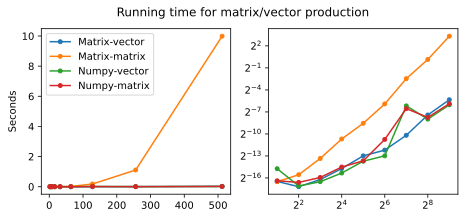

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
vis_data = {
    'Matrix-vector': vec_times,
    'Matrix-matrix': mat_times,
    'Numpy-vector': np_vec_times,
    'Numpy-matrix': np_mat_times
}


for data in vis_data.items():
    axes[0].plot(domain, data[1], '.-', ms=8, label=data[0])
    axes[0].set_ylabel('Seconds')
    # log-log scale 
    axes[1].loglog(domain, data[1], '.-', ms=8, base=2)

axes[0].legend(loc='upper left')
fig.suptitle('Running time for matrix/vector production');

## Numeric computing with GPU

It's important to allocate GPU memeory before your computing as `JAX` will preallocate 90% of the total GPU memory when the first `JAX` operation is run. This means _if you do not set up the memoery usage_, 

- you cannot run too many GPU applications with different script
- you cannot run jupyter notebook and other script at the same time 
- it will give you `out of memeory` error. 

Three options:

`XLA_PYTHON_CLIENT_PREALLOCATE=false`

This disables the preallocation behavior. JAX will instead allocate GPU memory as needed, potentially decreasing the overall memory usage. However, this behavior is more prone to GPU memory fragmentation, meaning a JAX program that uses most of the available GPU memory may OOM with preallocation disabled.

`XLA_PYTHON_CLIENT_MEM_FRACTION=.XX`

If preallocation is enabled, this makes JAX preallocate XX% of the total GPU memory, instead of the default 90%. Lowering the amount preallocated can fix OOMs that occur when the JAX program starts.

`XLA_PYTHON_CLIENT_ALLOCATOR=platform`

This makes JAX allocate exactly what is needed on demand, and deallocate memory that is no longer needed (note that this is the only configuration that will deallocate GPU memory, instead of reusing it). This is very slow, so is not recommended for general use, but may be useful for running with the minimal possible GPU memory footprint or debugging OOM failures.

In [9]:
# disable preallocate 
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.3


In [10]:
# test jax 
import jax
import jax.numpy as jnp 
import jax.random as jrd 
from jax import grad, jit, vmap

In [22]:
# test numpy 
domain = 2**np.arange(1,10)

vec_times = []
mat_times = []
np_vec_times = []
np_mat_times = []
jax_vec_times = []
jax_mat_times = []

for n in domain:
    foov = random_vector(n)
    foom = random_matrix(n)
    start = time.time()
    matrix_vector_prod(foom, foov)
    vec_times.append(time.time()-start)
    start = time.time()
    matrix_matrix_prod(foom, foom)
    mat_times.append(time.time()-start)
    # numpy
    start = time.time()
    np.array(foom) @ np.array(foov) 
    np_vec_times.append(time.time()-start)
    start = time.time()
    np.array(foom) @ np.array(foom)
    np_mat_times.append(time.time()-start)
    # jax
    start = time.time()
    foom = jnp.array(foom)
    foov = jnp.array(foov)
    jnp.dot(foom, foov.T)
    jax_vec_times.append(time.time()- start)
    start = time.time()
    jnp.dot(foom, foom.T)
    jax_mat_times.append(time.time()- start)

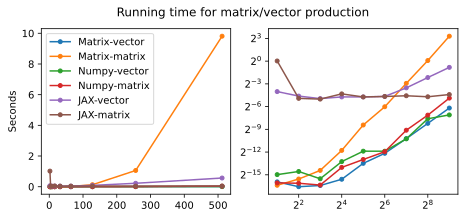

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
vis_data = {
    'Matrix-vector': vec_times,
    'Matrix-matrix': mat_times,
    'Numpy-vector': np_vec_times,
    'Numpy-matrix': np_mat_times,
    'JAX-vector': jax_vec_times,
    'JAX-matrix': jax_mat_times
}


for data in vis_data.items():
    axes[0].plot(domain, data[1], '.-', ms=8, label=data[0])
    axes[0].set_ylabel('Seconds')
    # log-log scale 
    axes[1].loglog(domain, data[1], '.-', ms=8, base=2)

axes[0].legend(loc='upper left')
fig.suptitle('Running time for matrix/vector production');

JAX is slower because it has to transfer data to the GPU every time. But once it finishing transferring
data, then it gains efficiency. 

In [24]:
# with a larger matrix 
domain = 2**np.arange(1,11)

vec_times = []
mat_times = []
np_vec_times = []
np_mat_times = []
jax_vec_times = []
jax_mat_times = []

for n in domain:
    foov = random_vector(n)
    foom = random_matrix(n)
    start = time.time()
    matrix_vector_prod(foom, foov)
    vec_times.append(time.time()-start)
    start = time.time()
    matrix_matrix_prod(foom, foom)
    mat_times.append(time.time()-start)
    # numpy
    start = time.time()
    np.array(foom) @ np.array(foov) 
    np_vec_times.append(time.time()-start)
    start = time.time()
    np.array(foom) @ np.array(foom)
    np_mat_times.append(time.time()-start)
    # jax
    start = time.time()
    foom = jnp.array(foom)
    foov = jnp.array(foov)
    jnp.dot(foom, foov.T).block_until_ready()  # run on GPU
    jax_vec_times.append(time.time()- start)
    start = time.time()
    jnp.dot(foom, foom.T).block_until_ready()  # run on GPU
    jax_mat_times.append(time.time()- start)

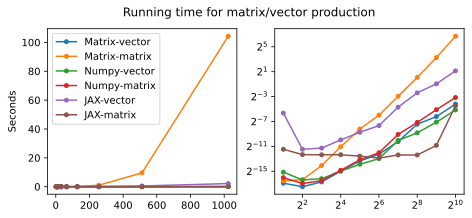

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
vis_data = {
    'Matrix-vector': vec_times,
    'Matrix-matrix': mat_times,
    'Numpy-vector': np_vec_times,
    'Numpy-matrix': np_mat_times,
    'JAX-vector': jax_vec_times,
    'JAX-matrix': jax_mat_times
}


for data in vis_data.items():
    axes[0].plot(domain, data[1], '.-', ms=8, label=data[0])
    axes[0].set_ylabel('Seconds')
    # log-log scale 
    axes[1].loglog(domain, data[1], '.-', ms=8, base=2)

axes[0].legend(loc='upper left')
fig.suptitle('Running time for matrix/vector production');

The JAX-vector takes more time as JAX needs to put arry into GPU which takes some time. 

### With JIT 

We need to find a function first

In [26]:
def f(x):  # function we're benchmarking (works in both NumPy & JAX)
  return x.T @ (x - x.mean(axis=0))

x_np = np.ones((1000, 1000), dtype=np.float32)  # same as JAX default dtype
%timeit f(x_np)  # measure NumPy runtime

%time x_jax = jax.device_put(x_np)  # measure JAX device transfer time
f_jit = jax.jit(f)
%time f_jit(x_jax).block_until_ready()  # measure JAX compilation time
%timeit f_jit(x_jax).block_until_ready()  # measure JAX runtime

3.3 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU times: user 93.3 ms, sys: 354 ms, total: 447 ms
Wall time: 14.1 ms
CPU times: user 524 ms, sys: 1.48 s, total: 2.01 s
Wall time: 82.6 ms
164 µs ± 3.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
def prod(x, y):
    return x @ y

In [28]:
# with a larger matrix and JIT
domain = 2**np.arange(1,11)

vec_times = []
mat_times = []
np_vec_times = []
np_mat_times = []
jax_vec_times = []
jax_mat_times = []

for n in domain:
    foov = random_vector(n)
    foom = random_matrix(n)
    start = time.time()
    matrix_vector_prod(foom, foov)
    vec_times.append(time.time()-start)
    start = time.time()
    matrix_matrix_prod(foom, foom)
    mat_times.append(time.time()-start)
    # numpy
    start = time.time()
    np.array(foom) @ np.array(foov) 
    np_vec_times.append(time.time()-start)
    start = time.time()
    np.array(foom) @ np.array(foom)
    np_mat_times.append(time.time()-start)
    # jax
    start = time.time()
    foom = jnp.array(foom)
    foov = jnp.array(foov)
    f_prod = jax.jit(prod)
    f_prod(foom, foov).block_until_ready()  # run on GPU
    jax_vec_times.append(time.time()- start)
    start = time.time()
    f_prod(foom, foom).block_until_ready()  # run on GPU
    jax_mat_times.append(time.time()- start)

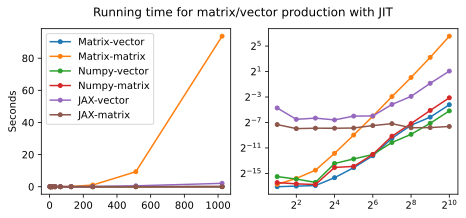

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
vis_data = {
    'Matrix-vector': vec_times,
    'Matrix-matrix': mat_times,
    'Numpy-vector': np_vec_times,
    'Numpy-matrix': np_mat_times,
    'JAX-vector': jax_vec_times,
    'JAX-matrix': jax_mat_times
}


for data in vis_data.items():
    axes[0].plot(domain, data[1], '.-', ms=8, label=data[0])
    axes[0].set_ylabel('Seconds')
    # log-log scale 
    axes[1].loglog(domain, data[1], '.-', ms=8, base=2)

axes[0].legend(loc='upper left')
fig.suptitle('Running time for matrix/vector production with JIT');

In [32]:
360*50*3 > 1000 * 1000

False

In [34]:
800*800*3 > 1000*1000

True

### Some other tests 

In [11]:
# test random from jax 
key = jrd.PRNGKey(0)
x = jrd.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [12]:
size = 1000
x = jrd.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

302 µs ± 89.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Using pytorch

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3090


In [ ]:
print(torch.cuda.mem_get_info(0))

(16685989888, 25447170048)


In [ ]:
16685989888/25447170048

0.655711022346527

Around 65% of memory is using. 

### Image Transformer Class



In [5]:
class ImageTransformer:
    """
    Image Transformer: read an image and transform it based on
    """
    
    def __init__(self, image):
        self.image = image 
        
    def stretch(self, a, b):
        """stretch the image"""
        mat = np.array(
            [
                [a, 0],
                [0, b]
            ]
        )
        
        self.image =  mat @ self.image
    
    def shear(self, a, b):
        mat = np.array(
            [
                [1, a],
                [b,1]
            ]
        )
        
        self.image =  mat @ self.image
    
    def reflection(self, a, b):
         mat = np.array(
             [
                [a**2-b**2, 2*a*b],
                [2*a*b,b**2-a**2]
                ])/(a**2 + b**2)
         
         self.image = mat @ self.image 
    
    def rotate(self, theta):
         mat = np.array(
            [
                [np.cos(theta), -np.sin(theta)],
                [np.sin(theta),np.cos(theta)]
            ]
        )
         
         self.image = mat @ self.image 
         
    def display(self):
        matplotlib_inline.backend_inline.set_matplotlib_formats('png')
        plt.plot(self.image[0], self.image[1], 'k,')
        # make plot square 
        plt.axis([-1, 1, -1, 1])
        plt.gca().set_aspect("equal");

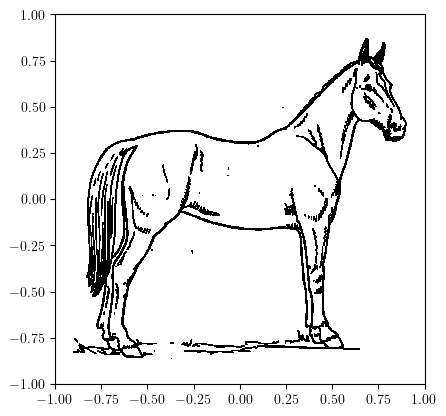

In [7]:
Horse = ImageTransformer(data)
Horse.display()

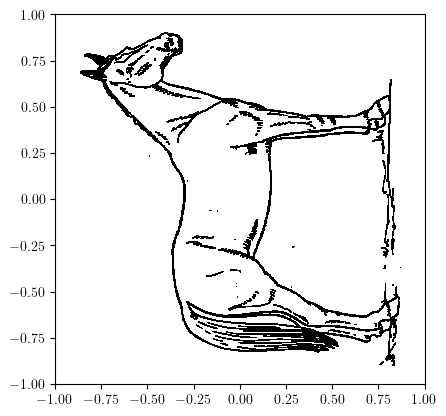

In [8]:
Horse.rotate(np.pi/2.)
Horse.display()

## Animation 

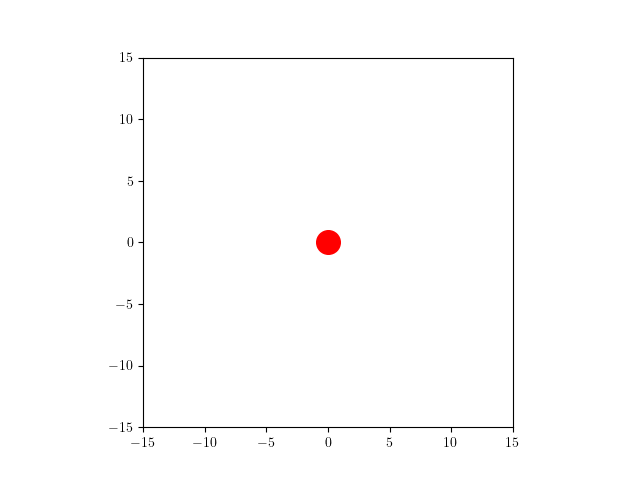

In [44]:
%matplotlib ipympl
from matplotlib.animation import FuncAnimation

# setup the figure
fig, ax = plt.subplots(1,1)  # Make a figure explicitly.
plt.axis([-15,15,-15,15])  # Set the window limits.
ax.set_aspect("equal")  # Make the window square.
ax.plot([0],[0], 'ro', markersize=17)  # Red dot for the sun.
earth_dot,  = ax.plot([],[], 'C0o', ms=8)  # Blue dot for the earth.
earth_path, = ax.plot([],[], 'C0-')  # Blue line for the earth.
moon_dot, = ax.plot([],[], 'o', ms=5, color='#E49E25')  # Green dot for the moon.
moon_path, = ax.plot([],[], '-', color='#E49E25')  # Green line for the moon.

def init():
    earth_dot.set_data([], [])
    earth_path.set_data([], [])
    moon_dot.set_data([], [])
    moon_path.set_data([], [])
        
    return earth_dot, earth_path, moon_dot, moon_path,
    
def animate(index):
    earth_dot.set_data(foo_ep[index, 0], foo_ep[index, 1])
    earth_path.set_data(foo_ep[:index, 0], foo_ep[:index, 1])
    moon_dot.set_data(foo_mp[index, 0], foo_mp[index, 1])
    moon_path.set_data(foo_mp[:index, 0], foo_mp[:index, 1])
    return earth_dot, earth_path, moon_dot, moon_path,

a = FuncAnimation(fig, animate, frames=foo_ep.shape[0], interval=20, blit=True)
plt.show()